In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import math
from sklearn.model_selection import cross_validate, train_test_split
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16


import tensorflow as tf
import keras.models as models
from keras.models import Model
from keras.layers import Input, concatenate
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adamax, Adam, SGD

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
from sklearn.utils import class_weight
from keras.regularizers import l2

class FCNModel:
    
    def __init__(self, **args):
        pass
    def initialize_model(self, dropout=False, weights=None):
        K.clear_session()
        inputs = Input((None,None,3))
        vgg16 = VGG16(include_top=False, weights=weights, input_tensor=inputs, input_shape=(None, None, 3))
        
        input_vgg16 = vgg16.get_layer('block3_pool').output
        if dropout:
            input_vgg16 = Dropout(0.5)(input_vgg16)
        output = UpSampling2D(2)(input_vgg16)
        output = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(output))
        output = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(output))
        output = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(output))
        if dropout:
             output = Dropout(0.25)(output)
        output = UpSampling2D(2)(output)
        output = BatchNormalization()(Conv2D(128, 3, padding='same', activation='relu')(output))
        output = BatchNormalization()(Conv2D(128, 3, padding='same', activation='relu')(output))
        if dropout:
             output = Dropout(0.25)(output)
        output = UpSampling2D(2)(output)
        output = BatchNormalization()(Conv2D(64, 3, padding='same', activation='relu')(output))
        output = BatchNormalization()(Conv2D(64, 3, padding='same', activation='relu')(output))
        if dropout:
             output = Dropout(0.25)(output)
        output = Conv2D(2, 1, padding='same', activation='softmax')(output)

        self.model = Model(inputs, output)

    
    def fit(self, imgs, gt_imgs, augment=False, dropout = False, weights=None,
            num_batches=2, steps_per_epoch=64, epochs=5, validation_steps=32, verbose = 0, seed=42):
        self.initialize_model(dropout, weights)

        def one_hot_encode(gt):
            gt = np.round(gt).astype(int)
            encoded = np.zeros((gt.shape[0], gt.shape[1], 2))
            for i in range(gt.shape[0]):
                for j in range(gt.shape[1]):
                    encoded[i][j][gt[i][j]] = 1
            return encoded
        
        def generate_train(batch_size, imgs, gt_imgs, augment=False, seed=1):
            np.random.seed(seed)
            while 1:
                batch_x = []
                batch_y = []
                for i in range(batch_size):
                    idx = np.random.choice(imgs.shape[0])
                    img = imgs[idx]
                    gt = one_hot_encode(gt_imgs[idx])
                    if augment:
                        if np.random.choice(2):
                            img_crop = np.flipud(img)
                            gt_crop = np.flipud(gt)
                        if np.random.choice(2):
                            img_crop = np.fliplr(img)
                            gt_crop = np.fliplr(gt)
                        rot = np.random.choice(4)
                        img_crop = np.rot90(img, rot)
                        gt_crop = np.rot90(gt, rot)
                    batch_x.append(img)
                    batch_y.append(gt)
                yield(np.array(batch_x), np.array(batch_y))
        
        train_generator = generate_train(num_batches, imgs, gt_imgs, augment=augment, seed=seed)

        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=verbose)
        
    def predict(self, imgs, batch_size=2):
        predictions = self.model.predict(imgs, batch_size)
        print(np.argmax(crop_and_one_hot(np.expand_dims(np.argmax(predictions, axis=3), -1)), axis=1).shape)
        return np.argmax(crop_and_one_hot(np.expand_dims(np.argmax(predictions, axis=3), -1)), axis=1)
    def get_params(self, deep=True):
        return {'x': None}
    
    def set_params(self, **params):
        pass

In [ ]:
from cross_validation import k_fold_model
from helpers import *
imgs, gt_imgs = load_training('training')
fcnModel = FCNModel()

for weights in (None, 'imagenet'):
    for augment in (False, True):
        for dropout in (False, True):
            fit_params = {'augment': augment, 'dropout': dropout, 'weights': weights,
                          'num_batches' : 8, 'steps_per_epoch': 32, 'epochs' : 10, 'verbose': 1}
            scoring_params = {'batch_size': 8}

            cv_score = k_fold_model(fcnModel, imgs, gt_imgs, fit_params=fit_params, scoring_params=scoring_params, n_fold=4)
            if weights:
                print("Fcn model with pre-training, augment %r, dropout %r"%(augment, dropout))
            else:
                print("Fcn model augment %r, dropout %r"%(window, augment, dropout))
            print("Accuracy: %.3f ± %.3f"%(cv_score['test_acc'].mean(), cv_score['test_acc'].std()))
            print("F1 score %.3f ± %.3f"%(cv_score['test_f1'].mean(), cv_score['test_f1'].std()))

Epoch 1/10
32/32 [==============================] - 93s 3s/step - loss: 0.6831 - acc: 0.6163
Epoch 2/10
32/32 [==============================] - 83s 3s/step - loss: 0.5301 - acc: 0.7654
Epoch 3/10
32/32 [==============================] - 83s 3s/step - loss: 0.4628 - acc: 0.7866
Epoch 4/10
32/32 [==============================] - 83s 3s/step - loss: 0.4055 - acc: 0.8128
Epoch 5/10
32/32 [==============================] - 83s 3s/step - loss: 0.3931 - acc: 0.8102
Epoch 6/10
25/32 [======================>.......] - ETA: 18s - loss: 0.3841 - acc: 0.8216

In [41]:
 K.clear_session()

In [33]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint('vgg_fcn.h5', monitor='val_loss', verbose=1, save_best_only=True)
model.fit_generator(generate, steps_per_epoch=32, epochs=10, validation_data=(X_test, y_test), callbacks=[mc])

Epoch 1/10
32/32 [==============================] - 30s 940ms/step - loss: 0.7936 - acc: 0.5992 - f1: 0.5992 - val_loss: 2.8125 - val_acc: 0.8139 - val_f1: 0.8139
Epoch 2/10
32/32 [==============================] - 28s 867ms/step - loss: 0.6178 - acc: 0.6986 - f1: 0.6986 - val_loss: 2.8413 - val_acc: 0.8233 - val_f1: 0.8233
Epoch 3/10
32/32 [==============================] - 28s 869ms/step - loss: 0.5340 - acc: 0.7699 - f1: 0.7699 - val_loss: 2.8465 - val_acc: 0.8233 - val_f1: 0.8233
Epoch 4/10
32/32 [==============================] - 28s 879ms/step - loss: 0.4872 - acc: 0.7902 - f1: 0.7902 - val_loss: 2.7503 - val_acc: 0.2283 - val_f1: 0.2283
Epoch 5/10
32/32 [==============================] - 28s 878ms/step - loss: 0.4531 - acc: 0.7890 - f1: 0.7890 - val_loss: 0.4269 - val_acc: 0.8201 - val_f1: 0.8201
Epoch 6/10
32/32 [==============================] - 28s 871ms/step - loss: 0.4024 - acc: 0.8184 - f1: 0.8184 - val_loss: 0.8064 - val_acc: 0.7208 - val_f1: 0.7208
Epoch 7/10
32/32 [====

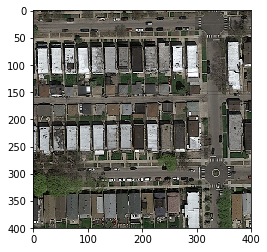

In [18]:
plt.imshow(X_test[0])

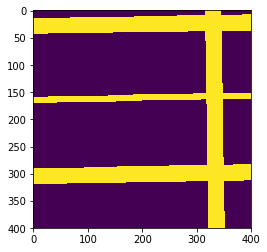

In [23]:
plt.imshow(np.argmax(y_test[0], axis=2))

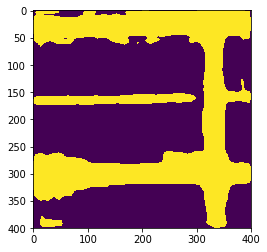

In [25]:
plt.imshow(np.argmax(model.predict(X_test[:1])[0], axis=2))

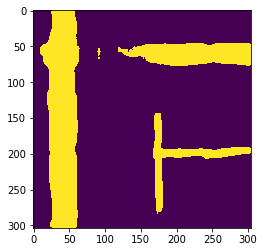

In [181]:
plt.imshow(np.argmax(model.predict(test_x[:4])[1], axis=2))

In [64]:
foreground_threshold = 0.25

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(img_number, img):
    """Reads a single image and outputs the strings that should go into the submission file"""
    patch_size = 16
    for j in range(0, img.shape[1], patch_size):
        for i in range(0, img.shape[0], patch_size):
            patch = img[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


with open('submission_test.csv', 'w') as f:
    f.write('id,prediction\n')
    for i in range(1, 51):
        print("Predicting %d"%i)
        im = mpimg.imread('/home/raph/ML_project2/test_set_images/test_%d/test_%d.png'%(i,i))
        crop = [im[i*304:(i+1)*304,j*304:(j+1)*304].tolist() for i in range(2) for j in range(2)]
        crop = model.predict(np.array(crop))
        crop = np.vstack([np.hstack(crop[i*2:(i+1)*2]) for i in range(2)])
        res = np.argmax(crop, axis=2)
        f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(i, res))

Predicting 1
Predicting 2
Predicting 3
Predicting 4
Predicting 5
Predicting 6
Predicting 7
Predicting 8
Predicting 9
Predicting 10
Predicting 11
Predicting 12
Predicting 13
Predicting 14
Predicting 15
Predicting 16
Predicting 17
Predicting 18
Predicting 19
Predicting 20
Predicting 21
Predicting 22
Predicting 23
Predicting 24
Predicting 25
Predicting 26
Predicting 27
Predicting 28
Predicting 29
Predicting 30
Predicting 31
Predicting 32
Predicting 33
Predicting 34
Predicting 35
Predicting 36
Predicting 37
Predicting 38
Predicting 39
Predicting 40
Predicting 41
Predicting 42
Predicting 43
Predicting 44
Predicting 45
Predicting 46
Predicting 47
Predicting 48
Predicting 49
Predicting 50


In [114]:
b = np.array([[[60, 34],
        [41, 54]],

       [[91, 84],
        [61, 87]]])
a = np.array([[0, 1],[1,0]])
m, n = a.shape
I, J = np.ogrid[:m, :n]
b[I, J, a]

array([[60, 54],
       [84, 61]])

In [118]:
im = mpimg.imread('/home/raph/ML_project2/test_set_images/test_%d/test_%d.png'%(1,1))
crop = [im[i*304:(i+1)*304,j*304:(j+1)*304].tolist() for i in range(2) for j in range(2)]
crop = model.predict(np.array(crop))
crop = np.vstack([np.hstack(crop[i*2:(i+1)*2]) for i in range(2)])
idxs = np.argmax(crop, axis=2)
m, n = idxs.shape
I, J = np.ogrid[:m, :n]
crop[I, J, idxs]

(608, 608)

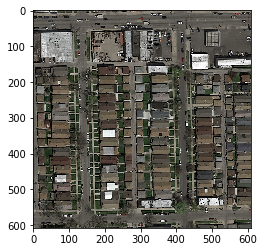

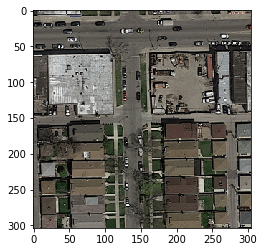

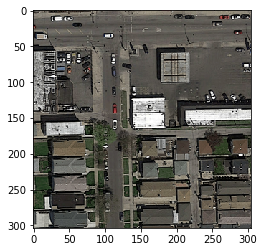

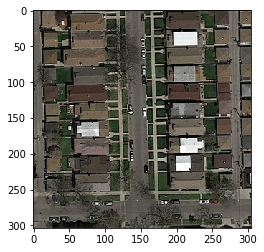

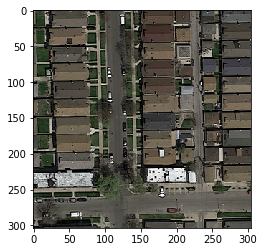

In [62]:
img = load_image('test/test_1/test_1.png')
plt.figure(0)
plt.imshow(img)
for i in range(len(img_crop)):
    plt.figure(i+1)
    plt.imshow(img_crop[i])

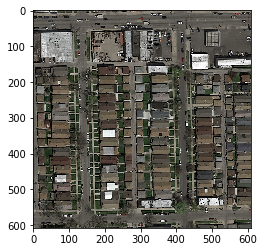

In [70]:
top = np.hstack(np.array(crop_img(img, window))[:2])
bottom = np.hstack(np.array(crop_img(img, window))[2:4])
plt.imshow(np.vstack((top, bottom)))

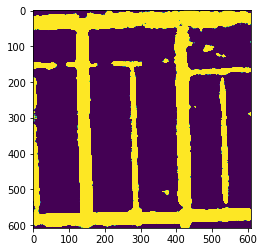

In [78]:
plt.imshow(load_image('predict/predict_1.png'))

In [79]:
load_image('predict/predict_1.png')

array([[ 1593,    78,    50, ...,    66,   216,  2552],
       [   28,     1,     1, ...,    35,    64,   205],
       [   33,     1,     2, ...,     3,     3,    94],
       ..., 
       [  889,    42,    18, ...,     2,     1,    19],
       [ 1471,    58,    18, ...,     1,     1,    70],
       [17993,  2396,   389, ...,    12,    38,  1179]], dtype=uint16)

In [87]:
import os
import numpy as np
import matplotlib.image as mpimg
import re


foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch




def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)

    print(im)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            print("{:03d}_{}_{},{}".format(img_number, j, i, label))
mask_to_submission_strings('predict/predict_1.png')

[[  2.43076216e-02   1.19020371e-03   7.62951095e-04 ...,   1.00709544e-03
    3.29594873e-03   3.89410257e-02]
 [  4.27252613e-04   1.52590219e-05   1.52590219e-05 ...,   5.34065766e-04
    9.76577401e-04   3.12809949e-03]
 [  5.03547722e-04   1.52590219e-05   3.05180438e-05 ...,   4.57770657e-05
    4.57770657e-05   1.43434806e-03]
 ..., 
 [  1.35652702e-02   6.40878920e-04   2.74662394e-04 ...,   3.05180438e-05
    1.52590219e-05   2.89921416e-04]
 [  2.24460214e-02   8.85023270e-04   2.74662394e-04 ...,   1.52590219e-05
    1.52590219e-05   1.06813153e-03]
 [  2.74555594e-01   3.65606174e-02   5.93575975e-03 ...,   1.83108263e-04
    5.79842832e-04   1.79903861e-02]]
0.0296082
001_0_0,0
0.959307
001_0_16,1
1.0
001_0_32,1
0.421145
001_0_48,1
5.70425e-05
001_0_64,0
0.000108124
001_0_80,0
0.00014353
001_0_96,0
0.000180128
001_0_112,0
0.000158849
001_0_128,0
0.92602
001_0_144,1
0.247732
001_0_160,0
0.106769
001_0_176,0
0.597727
001_0_192,1
0.530729
001_0_208,1
0.571392
001_0_224,1
0.63

1.0
001_496_32,1
0.183993
001_496_48,0
8.36266e-05
001_496_64,0
8.82162e-05
001_496_80,0
0.334202
001_496_96,1
0.0339517
001_496_112,0
6.68178e-05
001_496_128,0
4.4585e-05
001_496_144,0
0.791461
001_496_160,1
0.154449
001_496_176,0
0.000112356
001_496_192,0
9.6859e-05
001_496_208,0
6.65198e-05
001_496_224,0
0.000131013
001_496_240,0
0.000107946
001_496_256,0
3.95781e-05
001_496_272,0
0.000176134
001_496_288,0
0.00011492
001_496_304,0
0.000183645
001_496_320,0
9.87068e-05
001_496_336,0
0.000114025
001_496_352,0
9.91836e-05
001_496_368,0
8.47591e-05
001_496_384,0
7.33148e-05
001_496_400,0
7.02153e-05
001_496_416,0
7.94542e-05
001_496_432,0
0.000108303
001_496_448,0
0.000130596
001_496_464,0
0.000195387
001_496_480,0
9.4296e-05
001_496_496,0
0.000153425
001_496_512,0
8.76202e-05
001_496_528,0
0.349022
001_496_544,1
1.0
001_496_560,1
0.905367
001_496_576,1
0.000127675
001_496_592,0
0.661324
001_512_0,1
1.0
001_512_16,1
0.83316
001_512_32,1
0.00958022
001_512_48,0
8.50571e-05
001_512_64,0
9